# Implementation of FBProphet like regression model

The Prophet model is well suited to modelling strongly seasonal timeseries data. It uses Stan under the hood so it can also return uncertainty estimates (it actually returns MAP estimates by default and does a rough uncertainty approximation but there's an option to do full MCMC instead). However, to use Prophet requires having Stan MCMC installed so here we reimplement the basic idea of the model (without UQ). Unlike the full model we only fit a linear trend term and do not implement changepoints in the trend.

In [1]:
import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

### Feature extraction functions

In [2]:
def fourier_series(t, period, order):
    """
    Create fourier features to model seasonality (based on FBProphet).
    
    :param t: The timeseries.
    :param period: The period of the seasonality to model.
    :param order: Number of sin/cos components to use in the fourier series.
        The frequency of each component is `n/period` where `n` is in `[1,..,order]`.
        I.e., `n` is the number of cycles in the given period interval for each sinusoid.
    :return: Matrix with seasonality features.
    
    For example, if `t` is at daily frequency then use the following values (from Prophet):
        - yearly: period=365.25, order=10
        - monthly: period=30.5, order=5
        - weekly: period=7, order=3
        - daily: period=1, order=4

    If the data is monthly then use `period=12` for a yearly seasonality. 
    If hourly, then fit a `periodicity=24` to capture time of day trends.
    """
    return np.column_stack([
        fun((2.0 * (i + 1) * np.pi * t / period))
        for i in range(order)
        for fun in (np.sin, np.cos)
    ])


def dates_to_days(dates):
    """
    Convert dates (datetime objects) to days elapsed since epoch (1970 is standard).
    """
    return  np.array(
        (dates - datetime.datetime(1970, 1, 1)).dt.total_seconds()/ (3600 * 24.)
    ) 


def create_features(dates, yearly=True, weekly=True, daily=True):
    """
    Create seasonal features to use as input in a regression model, including an 
    intercept and a linear trend term.
    Dates are assumed to be at daily frequency or more (not hourly).
    Can turn off the different seasonalities to fit as appropriate.
    """
    Phi = [np.ones((len(dates), 1)),                  # column vector of 1s
           np.array([range(len(dates))]).transpose()] # column vector of 0, 1, ...

    days = dates_to_days(dates)
    if yearly:
        Phi.append(fourier_series(days, period=365.25, order=10))
    if weekly:
        Phi.append(fourier_series(days, period=7, order=6))
    if daily:
        Phi.append(fourier_series(days, period=1, order=4))

    return np.concatenate(Phi, axis=1)

### FBProphet example

In [3]:

df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df['dt'] = pd.to_datetime(df['ds'])
df.head()

,ds,y,dt
0,2007-12-10,9.590761,2007-12-10
1,2007-12-11,8.519590,2007-12-11
2,2007-12-12,8.183677,2007-12-12
3,2007-12-13,8.072467,2007-12-13
4,2007-12-14,7.893572,2007-12-14


In [4]:
X = create_features(df['dt'])

Plot the first 3 yearly seasonality sin features for illustration.

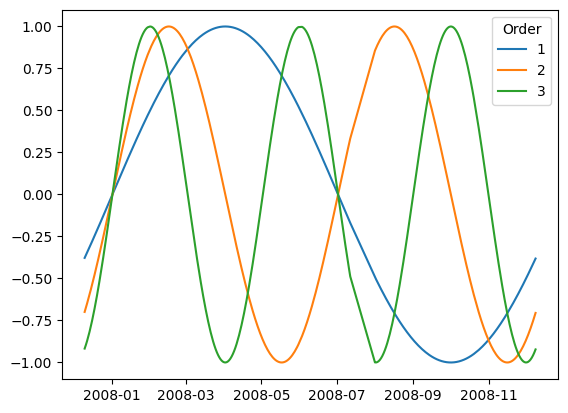

In [5]:
# 337 is where the first year of data ends - clearly there are missing values
plt.plot(df.iloc[:337]['dt'], X[:337,2], label="1")
plt.plot(df.iloc[:337]['dt'], X[:337,4], label='2')
plt.plot(df.iloc[:337]['dt'], X[:337,6], label='3')
plt.legend(title="Order")

In [6]:
m = LinearRegression()
m.fit(X, df['y'])

LinearRegression()

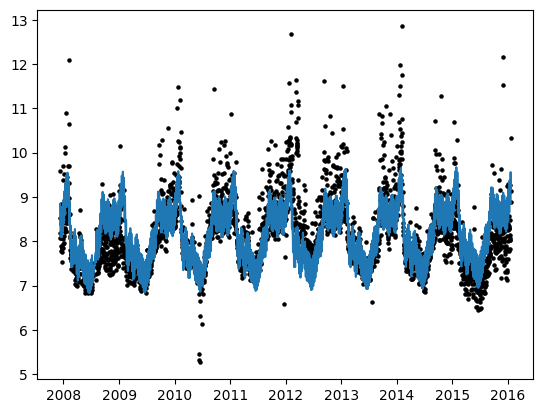

In [7]:
plt.plot(df['dt'], m.predict(X))
plt.scatter(df['dt'], df['y'], color='black', s=5)

Same as above but add a slope to the data to show that this gets fitted too.

In [8]:
slope = 0.005
df['y'] = df['y'] + slope * np.arange(df.shape[0])

In [9]:
X = create_features(df['dt'])
m = LinearRegression()
m.fit(X, df['y'])

LinearRegression()

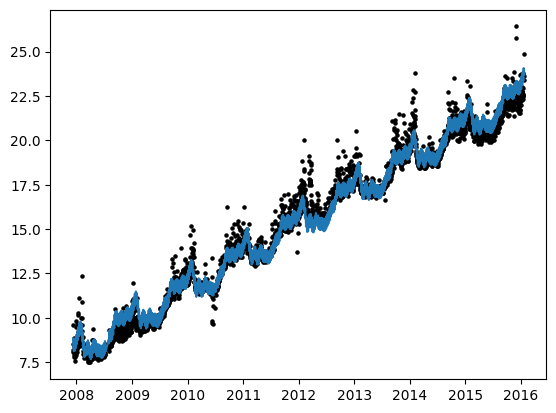

In [10]:
plt.plot(df['dt'], m.predict(X))
plt.scatter(df['dt'], df['y'], color='black', s=5)